<a href="https://colab.research.google.com/github/aliciama16/soviet-space-dreams/blob/main/Soviet_Space_Code_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Setup and Load Data
Before we can begin, you'll need to download my image dataset to use. Please **[download it here](https://drive.google.com/file/d/1zbz8Mua7zP4U4a3ikZRgAgX26FwxZEqt/view?usp=sharing)** and then upload both files UNZIPPED into your Google Drive.

# Mount Google Drive and Load the Dataset
Next, you'll need to connect your Google Drive so this notebook can access the dataset of images you just uploaded. Click the "Run" button on the next cell, then click the link that appears, log into your Google account, and grant all permissions.

In [5]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Find the File Path to the Folders
1. Click on the folder icon on the left side of your screen.
2. Click on "drive" to expand your drive
3. Click on "MyDrive" to view all your folders <br>
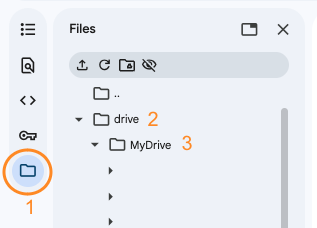 <br>


4. Scroll until you find the "Soviet_Space_Images" folder, and expand that to see the two folders within.
5. RIGHT CLICK on the Tekhnika_Molodezhi folder and "copy path"
6. Paste that link below next to posters_folder = and paste your link between the quotes (replacing mine)
7. Do the same for the USSR_Posters folder and paste that link next to magazines_folder = and paste your link between the quotes (replacing mine)

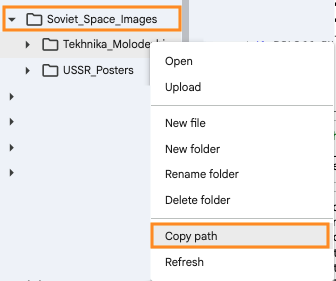

In [6]:
# Setting paths to the image folders
posters_folder = "/content/drive/MyDrive/Soviet_Space_Images/USSR_Posters" #paste your unique path between the quotes
magazines_folder = "/content/drive/MyDrive/Soviet_Space_Images/Tekhnika_Molodezhi" #paste your unique path between the quotes

# Feature Extraction using ResNet50

Now that we've loaded our image data, we can use a pre-trained convolutional neural network (CNN) to automatically analyze the images. For this project, I used ResNet50 to extract visual features from each image. In this step, the CNN turns every image into a numerical description (vector) of what the model sees (i.e. shapes, colors, and textures).

We will use these numerical vectors and feed them into U-MAP to see patterns visually (in the next step).

Code references:

*   https://docs.pytorch.org/vision/main/models.html
*   https://pytorch.org/hub/pytorch_vision_densenet/

In [7]:
# Before running code we need to 'import' libraires -- think of this as downloading the apps you want to use on an iphone
import os
import numpy as np
import cv2
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# --------------------------------------------------------------------------
# ResNet50
# --------------------------------------------------------------------------

# Load pre-trained ResNet50 for feature extraction
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # remove classification layer (do not need for this project)
model.eval() #running in evaluation mode (not training the model)

# Image preprocessing function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Extract image features
def extract_features(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(img).flatten().numpy()
    return features

# Process images from both folders
image_paths = []
features = []
labels = []

for folder, label in [(posters_folder, "poster"), (magazines_folder, "magazine")]:
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img_features = extract_features(img_path)
            features.append(img_features)
            image_paths.append(img_path)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert to NumPy array for next step
features = np.array(features)


 # UMAP Visualization

 Now,  we have hundreds/thousands of numerical vectors describing each image using ResNet50, but they exist in a (dimensional) space we cannot visualize.

 To make these patterns visible, we will use Uniform Manifold Approximation and Projection (UMAP). UMAP transforms those vectors and compresses them into 2 dimensions, or 2D points, where similar images appear closer together on the plot.

Here, red dots represent USSR Posters and blue dots represent TK magazine covers. If two dots are close together, it means ResNet50 ‘saw’ them as visually similar.

Choose different colors if you'd like! Explore [this matplotlib library](https://matplotlib.org/stable/gallery/color/named_colors.html) for options and try them out below where noted.

References:

*   https://umap-learn.readthedocs.io/en/latest/parameters.html#basic-umap-parameters

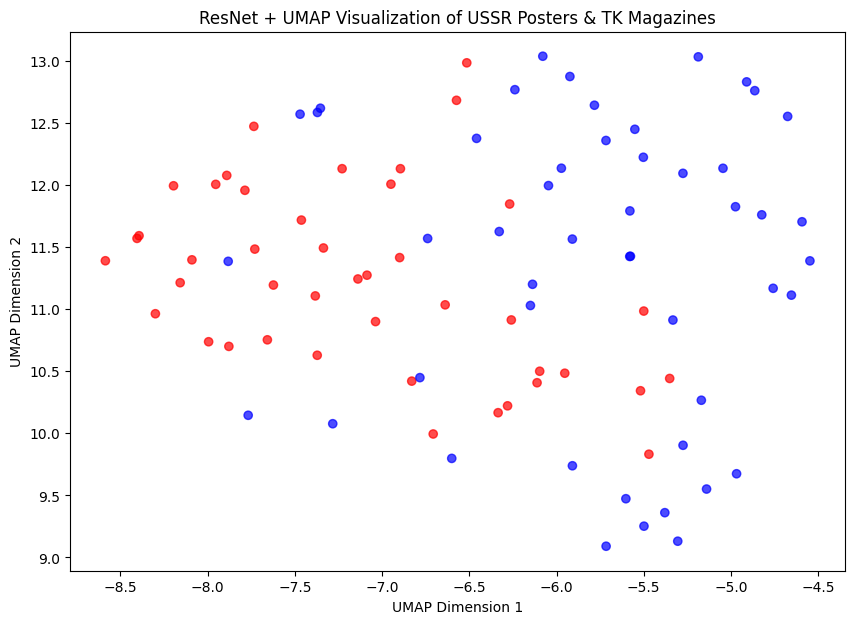

In [8]:
import umap
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------------------------
# Use UMAP to compress all the visual information ResNet50 extracted and turn it into a 2D map
# ----------------------------------------------------------------------------------------------

umap_model = umap.UMAP(
    n_neighbors=15, # How many nearby points UMAP looks at when building its clusters
    min_dist=0.05,  # How tight points can cluster
    n_components=2, # number of dimensions (we want 2 dimensions)
    metric='euclidean')
umap_embeddings = umap_model.fit_transform(features)

# Represent labels via color
colors = ["red" if label == "poster" else "blue" for label in labels] #Change color values here!

# --------------------------------------------------------------------------
# Plot visualization
# --------------------------------------------------------------------------

plt.figure(figsize=(10, 7))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=colors, alpha=0.7)
plt.title("ResNet + UMAP Visualization of USSR Posters & TK Magazines")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


# UMAP with Image Thumbnails

Now that UMAP has given each image a position on this 2D map, let's make the visualization easier to read and interpret by showing the actual images rather than dots.

Each image will now appear as a small thumbnail at its UMAP location.  Try adjusting the thumbnail size and zooms to see different ways to change the visualization.

References:


*   https://matplotlib.org/stable/gallery/text_labels_and_annotations/demo_annotation_box.html
*   https://pillow.readthedocs.io/en/stable/reference/Image.html



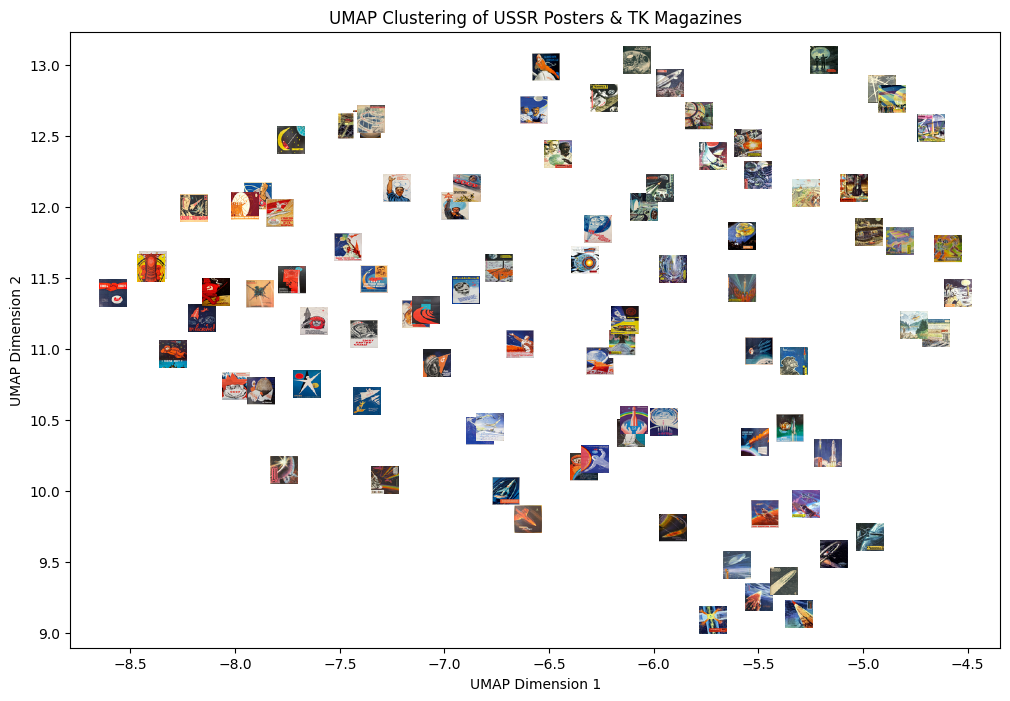

In [9]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# --------------------------------------------------------------------------
# Function to open images from their filepaths and resize the images to fit
# --------------------------------------------------------------------------

# Read and resize images
def get_thumbnail(path, size=(40, 40)): #Change the size of the thumbnails
    img = Image.open(path)
    img = img.resize(size, Image.LANCZOS)
    return np.array(img)

# -------------------------------------------------------------------------------
# Make a blank scatterplot as the base and overlay images at the same coordinate
# --------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 8)) #Change the size of the graph
ax.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    alpha=0.3)

# Add images to the plot
for i, path in enumerate(image_paths):
    img = get_thumbnail(path)
    imagebox = OffsetImage(img, zoom=0.5) # Scale the thumbnail size on the plot
    ab = AnnotationBbox(
        imagebox,
         (umap_embeddings[i, 0],
          umap_embeddings[i, 1]),
        frameon=False # False hides borders around the images
        )
    ax.add_artist(ab)

# --------------------------------------------------------------------------
# Plot visualization
# --------------------------------------------------------------------------
plt.title("UMAP Clustering of USSR Posters & TK Magazines")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


# Visualizing Relationships - Clustering and Connections with K-Means and KDTree

We can now see each image on the UMAP plot, but let's make the relationships clearer. We can use two tools together for this:

* K-Means - Clustering group images that the model sees as visually similar
* KDTree - draw lines (edges) connecting nearby images with the map

In this step we will also add a colored border to show it's category (red for USSR Poster, blue for TK magazine cover), and the connecting lines are also color coded by cluster group.

References:


*  https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
*   https://seaborn.pydata.org/tutorial/introduction.html
*   https://matplotlib.org/stable/users/explain/axes/legend_guide.html


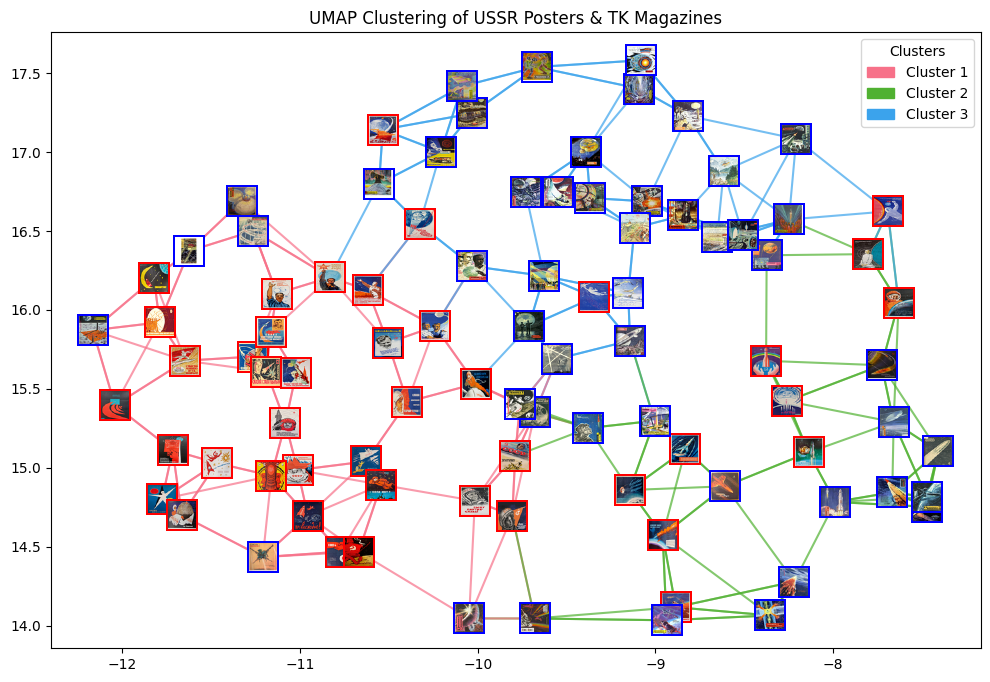

In [10]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import os
from scipy.spatial import KDTree
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.patches as mpatches  # Import for legend

# Function to read and resize images with a border
def get_thumbnail_with_border(path, label, size=(40, 40), border_thickness=3):
    img = Image.open(path).convert("RGB")
    img = img.resize(size, Image.LANCZOS)

    # Define border color based on category
    border_color = (255, 0, 0) if label == "poster" else (0, 0, 255)  # Red for posters, Blue for magazines

    # Create a new image with a border
    bordered_img = Image.new("RGB", (size[0] + 2 * border_thickness, size[1] + 2 * border_thickness), border_color)
    bordered_img.paste(img, (border_thickness, border_thickness))

    return np.array(bordered_img)

# Fit UMAP on extracted features
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
umap_embeddings = umap_model.fit_transform(features)

# -------------------------------------------------------------------------------
# Apply K-Means Clustering to Determine Groups
# -------------------------------------------------------------------------------

num_clusters = 3  # Adjust based on how many clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embeddings)

# Generate distinct colors for each cluster
cluster_colors = sns.color_palette("husl", num_clusters)  # "husl" generates distinct colors
cluster_color_map = {i: cluster_colors[i] for i in range(num_clusters)}

# -------------------------------------------------------------------------------
# Create a KDTree for nearest neighbor search
# -------------------------------------------------------------------------------

tree = KDTree(umap_embeddings)
threshold_distance = 2.5  # Adjust based on how close you want clusters to connect

edges = []
edge_colors = []
for i in range(len(umap_embeddings)):
    distances, indices = tree.query(umap_embeddings[i], k=5)  # Find 5 nearest neighbors
    for j in indices:
        if j != i and np.linalg.norm(umap_embeddings[i] - umap_embeddings[j]) < threshold_distance:
            edges.append((i, j))
            edge_colors.append(cluster_color_map[cluster_labels[i]])  # Assign edge color based on cluster

# -------------------------------------------------------------------------------
# Create plot
# -------------------------------------------------------------------------------

# Plot UMAP with images and colored edges
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot base layer (invisible points for structure)
ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], alpha=0.0)  # Hidden points to set the scale

# Draw edges with different colors
for (i, j), edge_color in zip(edges, edge_colors):
    ax.plot([umap_embeddings[i, 0], umap_embeddings[j, 0]],
            [umap_embeddings[i, 1], umap_embeddings[j, 1]],
            color=edge_color, alpha=0.7, linewidth=1.5)

# Add images with colored borders
for i, path in enumerate(image_paths):
    img = get_thumbnail_with_border(path, labels[i])
    imagebox = OffsetImage(img, zoom=0.5)
    ab = AnnotationBbox(imagebox, (umap_embeddings[i, 0], umap_embeddings[i, 1]), frameon=False)
    ax.add_artist(ab)

# Add a legend for clusters
legend_patches = [mpatches.Patch(color=cluster_colors[i], label=f'Cluster {i+1}') for i in range(num_clusters)]
ax.legend(handles=legend_patches, title="Clusters", loc="upper right", fontsize=10)

# Save high-resolution versions
plt.savefig("UMAP_Clustering.png", dpi=600, bbox_inches="tight")  # High-resolution PNG
plt.savefig("UMAP_Clustering.pdf", bbox_inches="tight")  # Vector PDF (best for zooming)
plt.savefig("UMAP_Clustering.svg", bbox_inches="tight")  # Scalable SVG format

plt.title("UMAP Clustering of USSR Posters & TK Magazines")
plt.show()


# Cluster Visualizations as a Grid

After looking at the entire dataset with UMAP, this step isolates each K-Means cluster and displays them as a grid of images.

If you want to change the number of clusters change in the above code: "num_clusters = 3  # Adjust based on how many clusters you want!" and then rerun the below code chunk.

Each cluster represents a group of images that are visually similar, determined by ResNet-50. As before, the USSR posters are outlined in red, while the TK magazines are outlined in blue.

References:

*   https://pillow.readthedocs.io/en/stable/reference/ImageOps.html
*   https://www.w3schools.com/css/css_border_color.asp






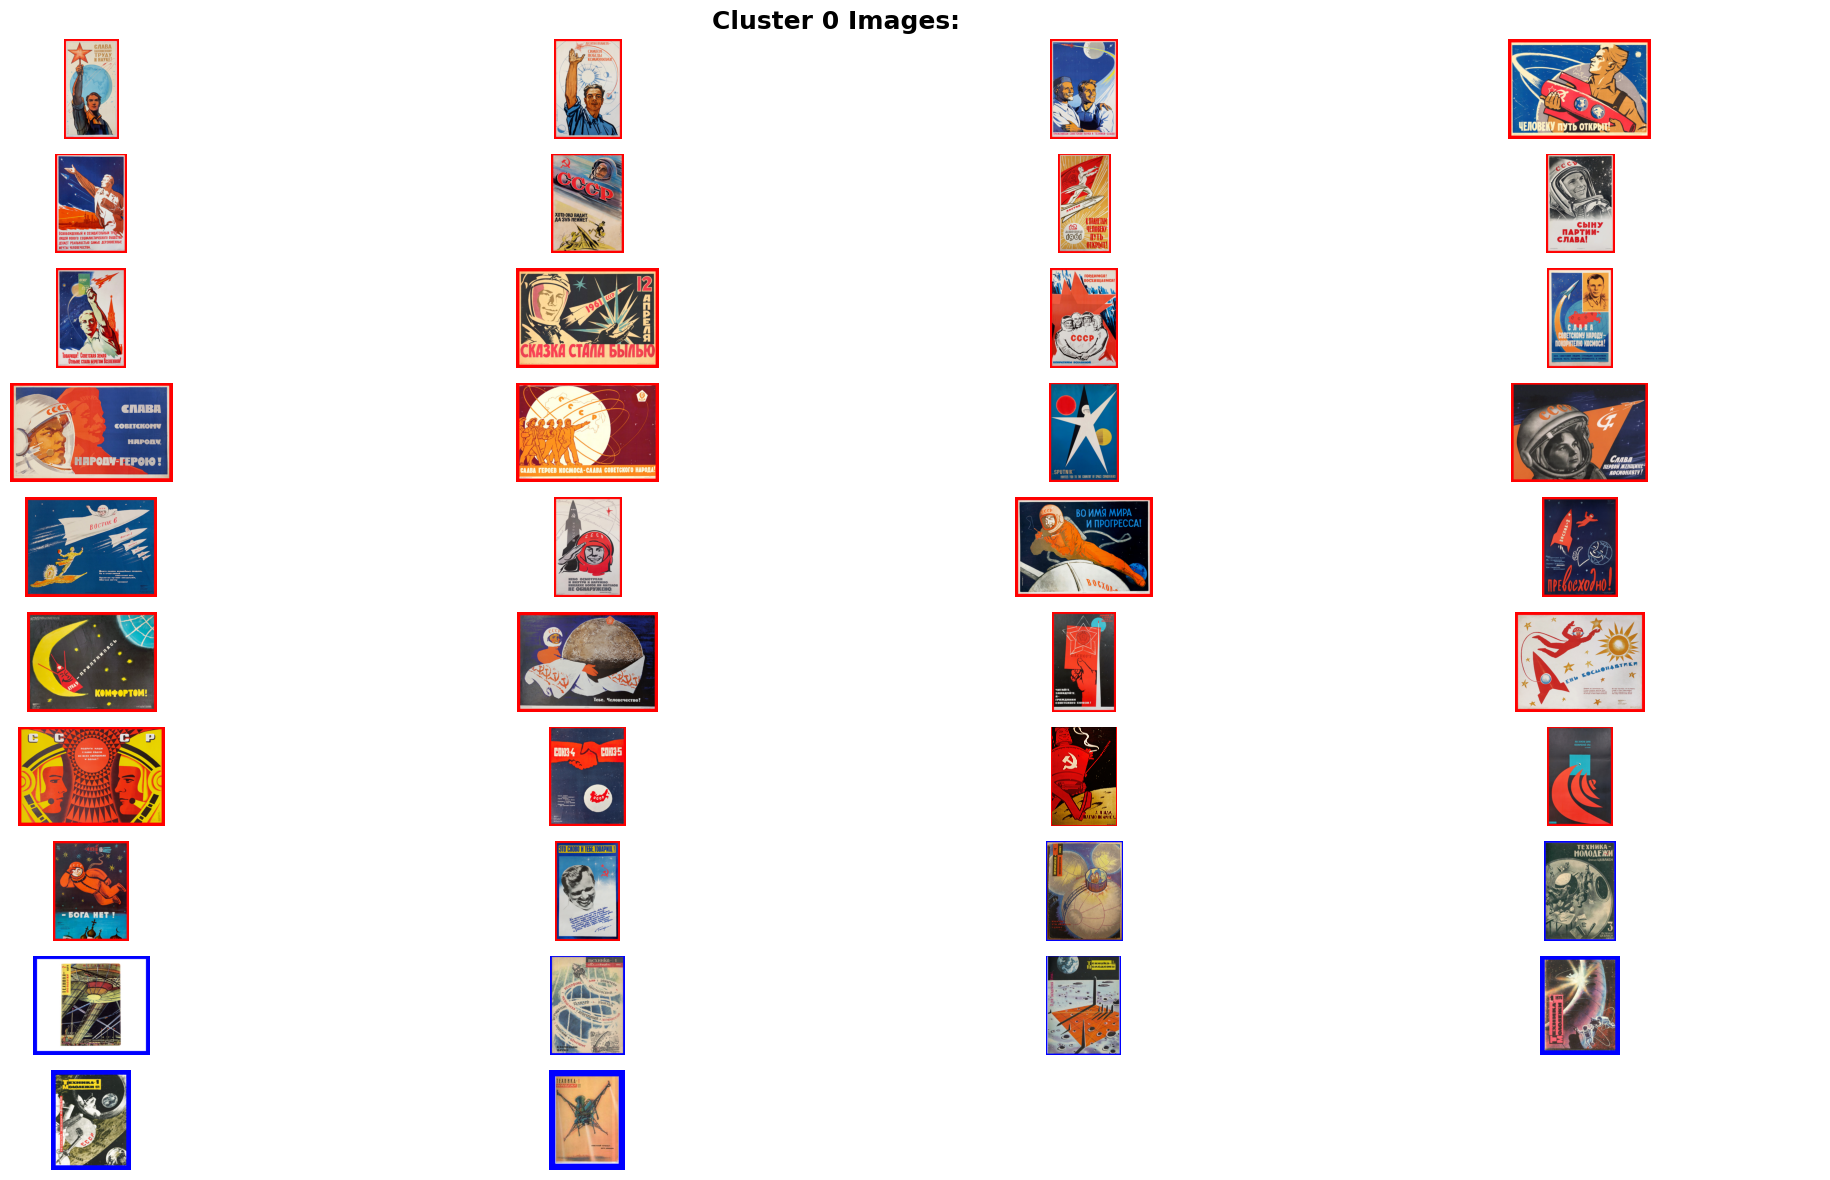

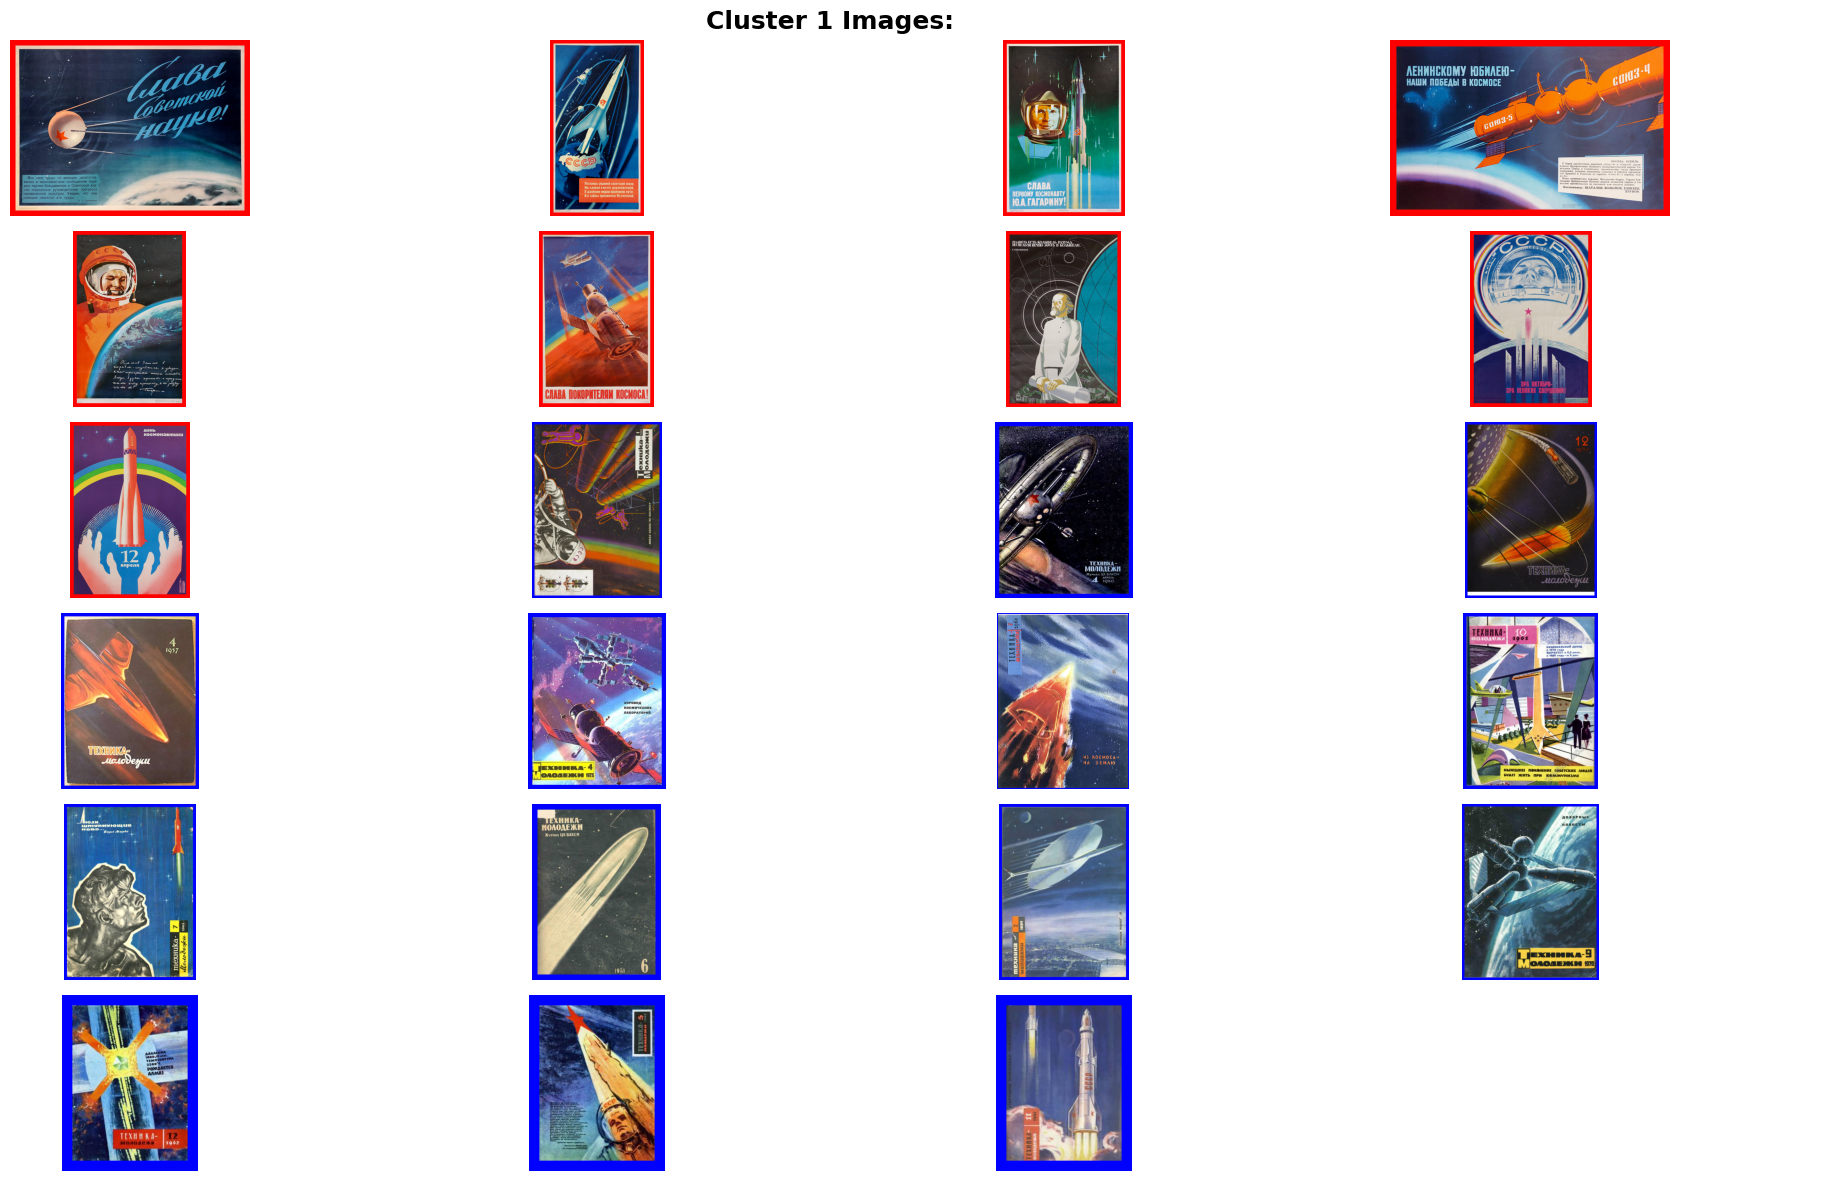

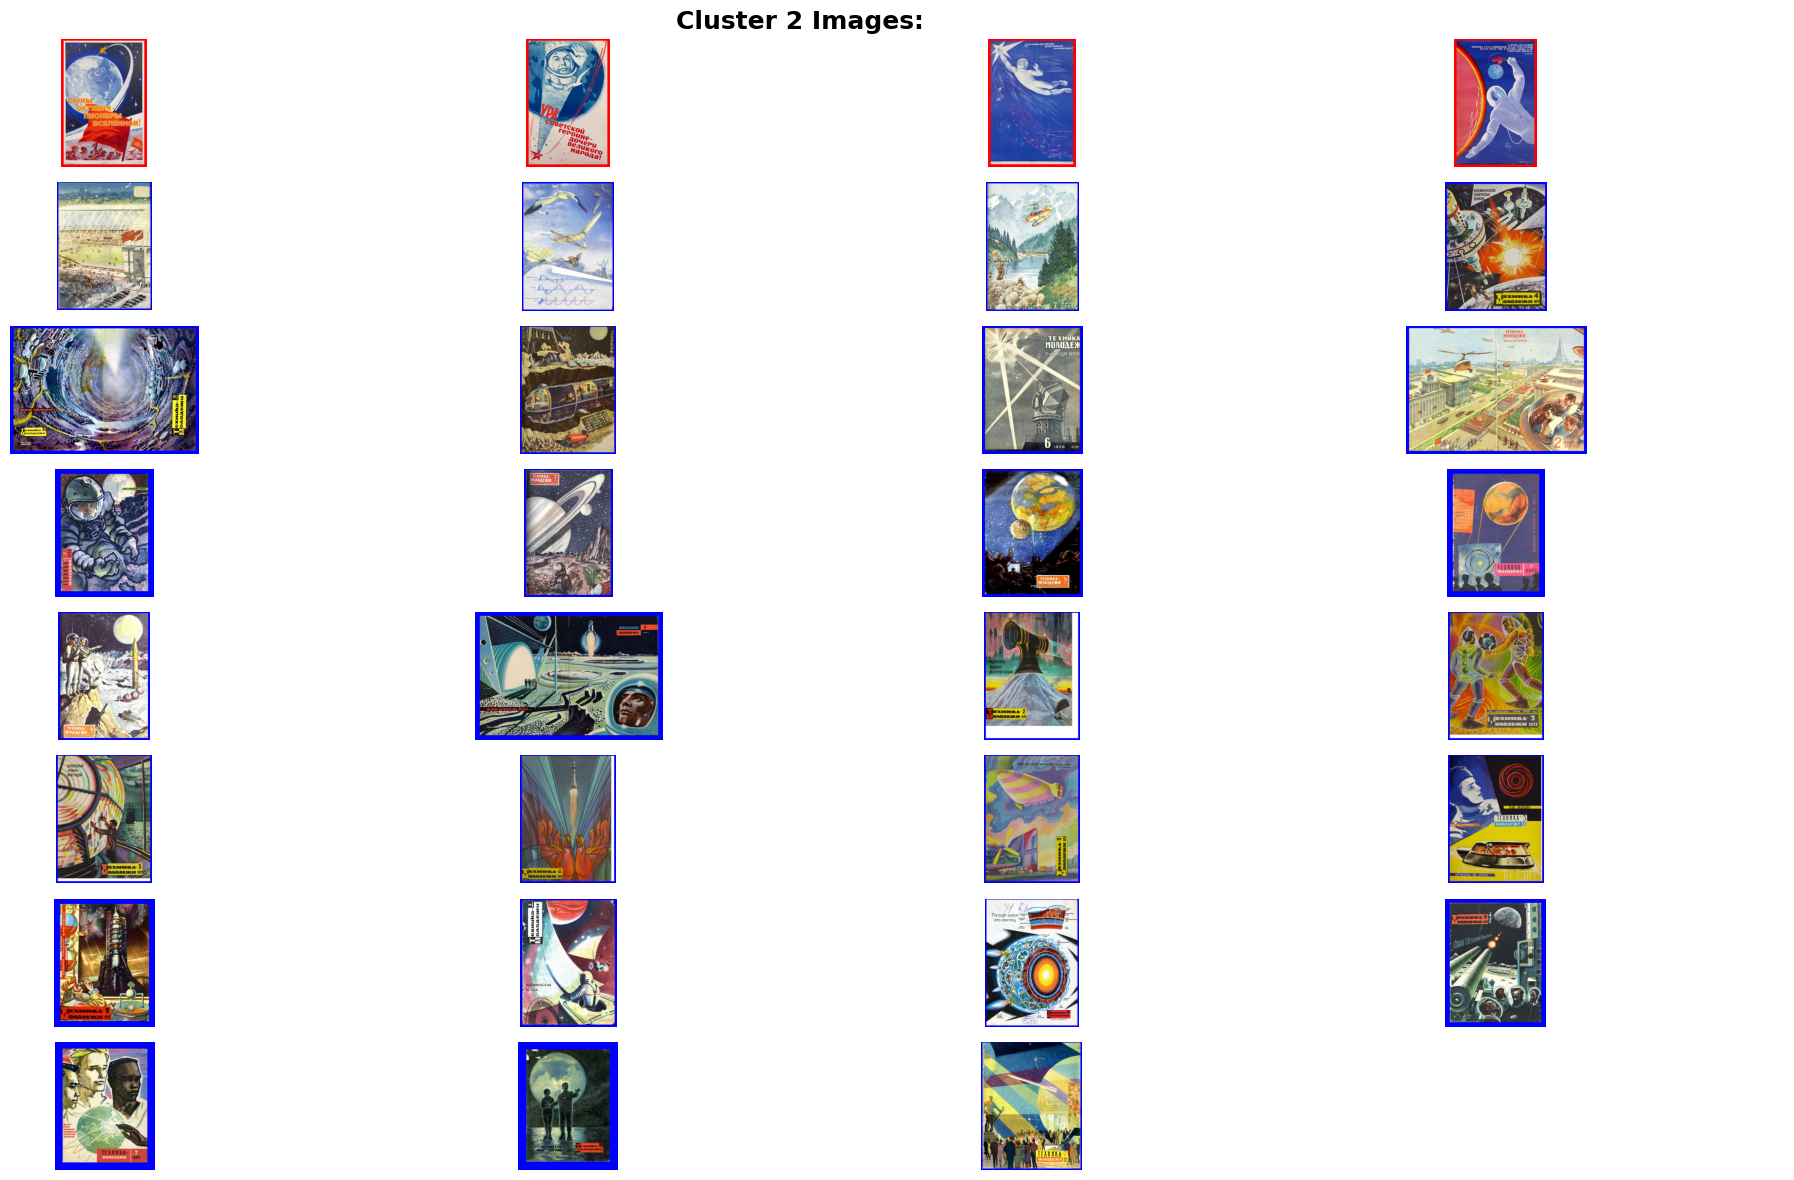

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

# --------------------------------------------------------------------------
# Create borders
# --------------------------------------------------------------------------

# Function to add a thicker border based on type (poster/magazine)
def add_border(img_path, label, border_thickness=20):  # Can adjust thickness here
    img = Image.open(img_path).convert("RGB")

    # Define border color: Red for posters, Blue for magazines
    border_color = (255, 0, 0) if label == "poster" else (0, 0, 255) #can change these colors too

    # Add border
    img_with_border = ImageOps.expand(img, border=border_thickness, fill=border_color)

    return img_with_border

# --------------------------------------------------------------------------
# Display clusters in grid form
# --------------------------------------------------------------------------

# Function to display images in a grid for a given cluster
def show_cluster(cluster_id, image_paths, labels, cluster_labels):
    # Select images and their labels that belong to the given cluster
    cluster_images = [image_paths[i] for i in range(len(cluster_labels)) if cluster_labels[i] == cluster_id]
    cluster_image_labels = [labels[i] for i in range(len(cluster_labels)) if cluster_labels[i] == cluster_id]

    num_images = len(cluster_images)

    cols = min(4, num_images)  # Max 4 images per row (instead of 5) for bigger images. Feel free to change this!
    rows = (num_images // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))  # Larger figure size - feel free to change this too!
    axes = axes.flatten()

    # Set title only once at the top
    fig.suptitle(f"Cluster {cluster_id} Images:", fontsize=18, fontweight="bold")

    for i in range(len(cluster_images)):
        img_with_border = add_border(cluster_images[i], cluster_image_labels[i], border_thickness=20)  # Thicker border
        axes[i].imshow(img_with_border)
        axes[i].axis("off")  # Remove axis labels

    # Hide any extra empty space
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()  # Ensure spacing is optimized
    plt.show()

# Show a grid for each cluster with bigger images and color-coded outlines
for cluster_id in range(num_clusters):
    show_cluster(cluster_id, image_paths, labels, cluster_labels)

# Explore Relationships within Clusters

To take a closer look at the relationships within the clusters, I used a cosine similarity search, which measures how close two vectors are (essentially, how similar the model's understanding of the two images are) to take a closer look within the groups. Each image ResNet-50 'feature vector' allows us to identify which images the model considered most similar.

References:

*   https://www.ethanrosenthal.com/2016/12/05/recasketch-keras/


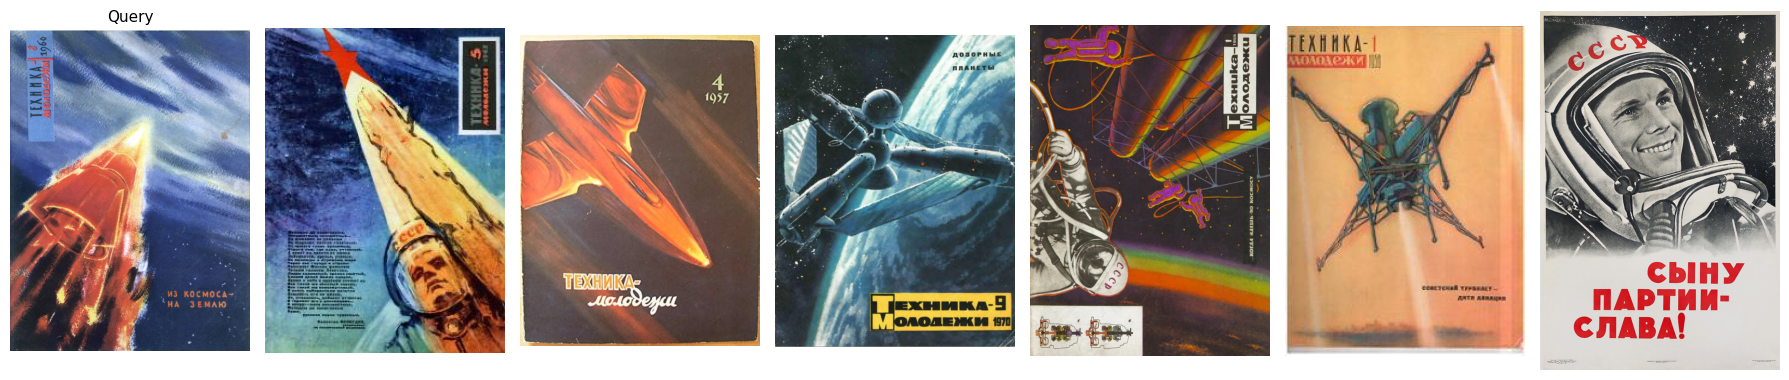

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

# ------------------------------------------------------------------------
# Look through both image paths
# ------------------------------------------------------------------------
image_paths = []
for folder in (posters_folder, magazines_folder):
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, fname))

# Extract existing extract_features for each image
feature_dict = {p: extract_features(p) for p in image_paths}

# Turn all the information into one big matrix for comparison
image_names = np.array(image_paths)
feature_matrix = np.vstack([feature_dict[p] for p in image_names])

# ------------------------------------------------------------------------
# Pick your Query Image!
# ------------------------------------------------------------------------
query_image_path = "/content/drive/MyDrive/Soviet_Space_Images/Tekhnika_Molodezhi/TM_1960_08.jpg" #Change this to whatever image you want in the dataset!
query_features = extract_features(query_image_path)

sims = cosine_similarity(query_features.reshape(1, -1), feature_matrix)[0] # Compare the query image to all other images
top_k = 6 #CHANGE THIS TO HOW MANY TOP MATCHES YOU WANT TO SEE!
ranked = sims.argsort()[::-1] #Sort so similar images are first

# Remove the query image, so its not logged as a match
try:
    q_idx = np.where(image_names == query_image_path)[0][0]
    ranked = ranked[ranked != q_idx]
except IndexError:
    pass

top_idx = ranked[:top_k]

# ------------------------------------------------------------------------
# Show results visuavisualization
# ------------------------------------------------------------------------

fig, axes = plt.subplots(1, top_k + 1, figsize=(18, 5))

axes[0].imshow(Image.open(query_image_path))
axes[0].set_title("Query", fontsize=11)
axes[0].axis("off")

for i, idx in enumerate(top_idx, start=1):
    axes[i].imshow(Image.open(image_names[idx]))
    axes[i].axis("off")

plt.tight_layout()
plt.show()


# Grad-CAM Heatmapping

At this point, we are using Grad-CAM heatmapping tools to see where the ResNet-50 CNN is 'looking.' Grad-CAM looks at the 'activations' from deep convolutional layers and weights them by the 'gradient of the class score.' The result is s heatmap which shows which regions of the image MOST influenced the model's decision.

References:


*   https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569/
*   https://github.com/jacobgil/pytorch-grad-cam
* https://jss367.github.io/model-explainability-with-grad-cam-in-pytorch.html




/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hoo

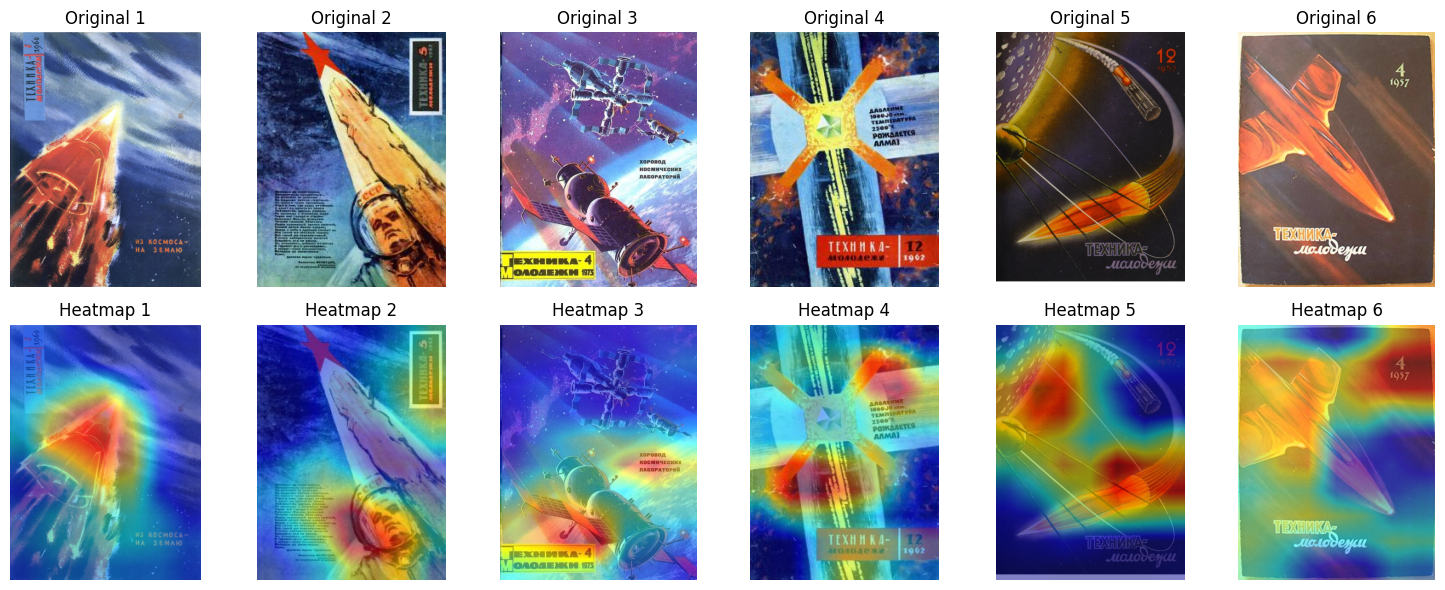

In [13]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
from PIL import Image

# --------------------------------------------------------------------------
# Load ResNet-50 to Evaluate its Convolution Layers
# --------------------------------------------------------------------------

model = models.resnet50(pretrained=True)
model.eval()

# --------------------------------------------------------------------------
# Convert images into 'tensors' ResNet-50 understands
# ------------------------------------------------------------------------

# Define transformation (keep aspect ratio)
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size  # Save original width & height

    transform = transforms.Compose([
        transforms.Resize(224),  # Keep aspect ratio
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform(image).unsqueeze(0), original_size, image  # Return tensor, size, and original image


# ------------------------------------------------------------------------
# Grad-CAM
# ------------------------------------------------------------------------
def get_gradcam(model, target_layer, input_tensor, original_size):
    activations = None # What the layer 'sees'
    gradients = None # How much each of these features influenced the final decision

    def forward_hook(module, input, output): # A hook is like placing a recorder inside the model. This records what comes OUT of a target layer (what it detected)
        nonlocal activations
        activations = output

    def backward_hook(module, grad_input, grad_output): # Records the gradients flowing backwards through the same layer (what mattered most)
        nonlocal gradients
        gradients = grad_output[0]

    # Register hooks and attach them to the last block layer
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    class_idx = output.argmax().item()  # Get the highest predicted class (e.g. rocket? satellite?)
    class_score = output[0, class_idx] # Score for that class (what image reasons made you pick that class?)

    # Backward pass - compute importance of each feature for the prediction
    model.zero_grad()
    class_score.backward()

    # Remove hooks - stop recording
    forward_handle.remove()
    backward_handle.remove()

    # Ensure gradients were captured
    if gradients is None or activations is None:
        raise ValueError("gradients or activations not properly captured")

    # Compute Grad-CAM heatmap
    weights = gradients.mean(dim=[2, 3], keepdim=True)  # Determine importance weights (which features mattered the most overall?)
    cam = (weights * activations).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)  #Only include features that POSITIVELY influenced the ending decision
    cam = cam.squeeze().detach().numpy()
    cam = cv2.resize(cam, original_size)

    # Normalize the heatmap
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Resize heatmap to match original image
    return cam

# ------------------------------------------------------------------------
# Generate Heatmaps
# ------------------------------------------------------------------------
def generate_heatmaps(image_paths):
    target_layer = model.layer4[-1]  # Choose last convolutional layer for better feature detection
    num_images = len(image_paths)

    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))  # Create 2 rows (original images on top, heatmap on bottom)

    # Give each image its own heatmap
    for i, image_path in enumerate(image_paths):
        input_tensor, original_size, original_image = preprocess_image(image_path)
        heatmap = get_gradcam(model, target_layer, input_tensor, original_size)

        # Apply color map
        heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)

        # Blend heatmap with original image
        alpha = 0.5
        overlay = cv2.addWeighted(np.array(original_image), 1 - alpha, heatmap_resized, alpha, 0)

        # Display original image
        axes[0, i].imshow(original_image)
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Original {i+1}")

        # Display heatmap overlay
        axes[1, i].imshow(overlay)
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Heatmap {i+1}")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# Choose Images to Run - I chose images in the same cluster near eachother
# ------------------------------------------------------------------------
image_paths = [
    "/content/drive/MyDrive/Soviet_Space_Images/Tekhnika_Molodezhi/TM_1960_08.jpg",
    "/content/drive/MyDrive/Soviet_Space_Images/Tekhnika_Molodezhi/TM_1962_05.jpg",
    "/content/drive/MyDrive/Soviet_Space_Images/Tekhnika_Molodezhi/TM_1973_04.jpg",
    "/content/drive/MyDrive/Soviet_Space_Images/Tekhnika_Molodezhi/TM_1962_12.jpg",
    "/content/drive/MyDrive/Soviet_Space_Images/Tekhnika_Molodezhi/TM_1957_12.jpg",
    "/content/drive/MyDrive/Soviet_Space_Images/Tekhnika_Molodezhi/TM_1957_04.jpg",

]

generate_heatmaps(image_paths)
